In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

### Load data 

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'

In [3]:
DS_LIST = ['facs', 'droplet']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}

In [4]:
dic_data_raw = {}
dic_data_processed = {}

# TMS FACs 
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_processed['facs'] = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='Liver')['Liver']

# TMS droplet 
dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_processed['droplet'] = dl.load_tms_processed(DATA_PATH, data_name='droplet', tissue='Liver')['Liver']

Trying to set attribute `.obs` of view, copying.


# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# load_tms_processed: load droplet data, tissue=[Bladder, Fat, Heart_and_Aorta, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, Mammary_Gland, Marrow, Pancreas, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


### Reproecss T-cell data

facs


2021-01-18 20:00:03,776 - harmonypy - INFO - Iteration 1 of 20
2021-01-18 20:00:05,899 - harmonypy - INFO - Iteration 2 of 20
2021-01-18 20:00:08,025 - harmonypy - INFO - Iteration 3 of 20
2021-01-18 20:00:09,512 - harmonypy - INFO - Iteration 4 of 20
2021-01-18 20:00:11,255 - harmonypy - INFO - Iteration 5 of 20
2021-01-18 20:00:13,142 - harmonypy - INFO - Iteration 6 of 20
2021-01-18 20:00:14,265 - harmonypy - INFO - Iteration 7 of 20
2021-01-18 20:00:15,570 - harmonypy - INFO - Iteration 8 of 20
2021-01-18 20:00:16,693 - harmonypy - INFO - Converged after 8 iterations
... storing 'tissue_celltype' as categorical


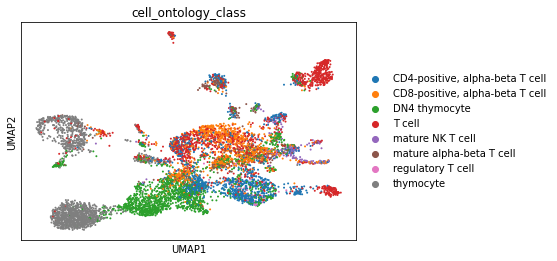

droplet


2021-01-18 20:00:56,302 - harmonypy - INFO - Iteration 1 of 20
2021-01-18 20:01:04,269 - harmonypy - INFO - Iteration 2 of 20
2021-01-18 20:01:12,258 - harmonypy - INFO - Iteration 3 of 20
2021-01-18 20:01:20,142 - harmonypy - INFO - Converged after 3 iterations
... storing 'tissue_celltype' as categorical


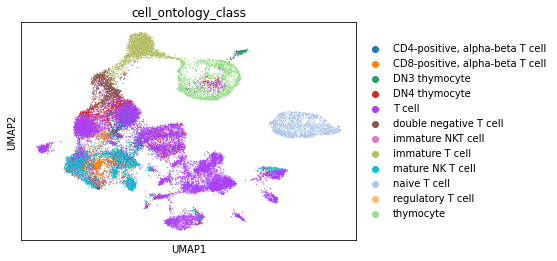

In [7]:
# # Reprocess t cell data
# dic_data_proc = {}
# for ds in DS_LIST:
#     print(ds)
#     ind_select = [('thymocyte' in x) | ('T cell' in x)  for x in dic_data_raw[ds].obs['tissue_celltype']]
#     adata = dic_data_raw[ds][ind_select,:].copy()
#     sc.pp.filter_cells(adata, min_genes=250)
#     sc.pp.filter_genes(adata, min_cells=50)
#     adata.obs['batch_harmony'] = adata.obs['mouse.id']
#     adata.obs['batch_harmony'] = adata.obs['batch_harmony'].astype('category')

#     sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
#                                 min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
#     sc.pp.scale(adata, max_value=10, zero_center=False)
#     sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
#     sc.external.pp.harmony_integrate(adata, key='batch_harmony', max_iter_harmony=20)
#     sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca_harmony")
#     sc.tl.leiden(adata, resolution=1)    
#     sc.tl.umap(adata)
#     sc.pl.umap(adata, color='cell_ontology_class')
#     adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc_tcell/'
#                 'tcell.%s.h5ad'%ds)

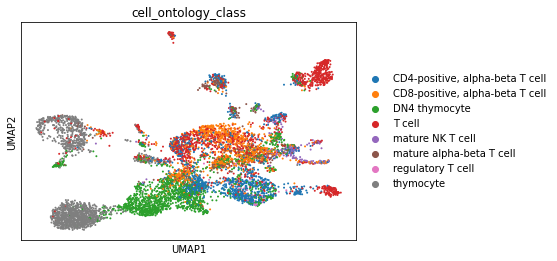

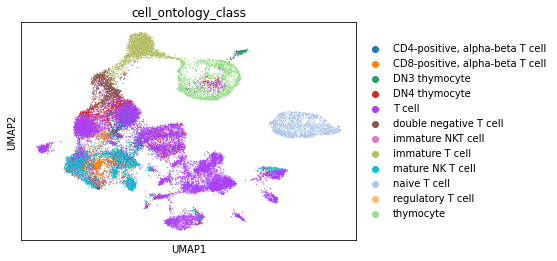

In [10]:
dic_data_proc = {}
for ds in DS_LIST:   
    dic_data_proc[ds] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                  'tms_proc_tcell/tcell.%s.h5ad'%ds)
    sc.pl.umap(dic_data_proc[ds], color='cell_ontology_class')

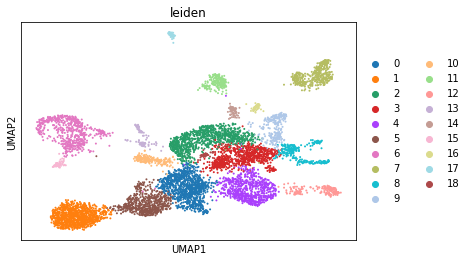

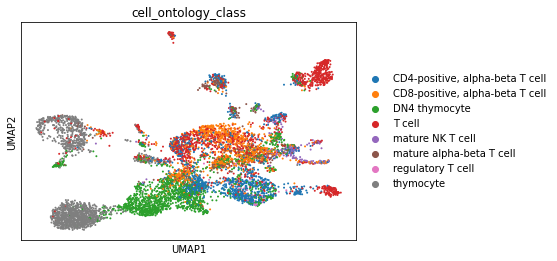

cell
leiden cell_ontology_class                   
0      CD4-positive, alpha-beta T cell  228.0
       CD8-positive, alpha-beta T cell  143.0
       DN4 thymocyte                    613.0
       T cell                            28.0
       mature alpha-beta T cell          23.0
1      DN4 thymocyte                     40.0
       thymocyte                        970.0
2      CD4-positive, alpha-beta T cell  158.0
       CD8-positive, alpha-beta T cell  409.0
       T cell                           359.0
3      CD4-positive, alpha-beta T cell   24.0
       CD8-positive, alpha-beta T cell  356.0
       DN4 thymocyte                    155.0
       T cell                           113.0
       mature NK T cell                  24.0
       mature alpha-beta T cell         128.0
4      CD4-positive, alpha-beta T cell  457.0
       DN4 thymocyte                    120.0
       T cell                            62.0
       regulatory T cell                 40.0
5      DN4 thymocyte                    571.0
6      T cell                            45.0
       thymocyte                        509.0
7      DN4 thymocyte                     26.0
       T cell                           339.0
8      CD4-positive, alpha-beta T cell   37.0
       CD8-positive, alpha-beta T cell   46.0
       T cell                            34.0
       mature NK T cell                 114.0
9      CD4-positive, alpha-beta T cell   61.0
       CD8-positive, alpha-beta T cell   29.0
       DN4 thymocyte                     60.0
       T cell                            50.0
       mature NK T cell                  38.0
10     DN4 thymocyte                     27.0
       T cell                            39.0
       thymocyte                        103.0
11     CD4-positive, alpha-beta T cell   66.0
       T cell                            32.0
       mature alpha-beta T cell          76.0
12     CD4-positive, alpha-beta T cell   54.0
       T cell                           116.0
13     T cell                            42.0
14     mature alpha-beta T cell          34.0
15     DN4 thymocyte                     50.0
17     T cell                            41.0

In [11]:
# facs
adata = dic_data_proc['facs'].copy()
sc.pl.umap(adata, color='leiden')
sc.pl.umap(adata, color='cell_ontology_class')
temp_df = adata.obs.groupby(['leiden', 'cell_ontology_class']).agg({'cell':len})
temp_df.loc[temp_df['cell']>20]

Trying to set attribute `.uns` of view, copying.


# Before filter: n_cell=7526
# After filter: n_cell=6794


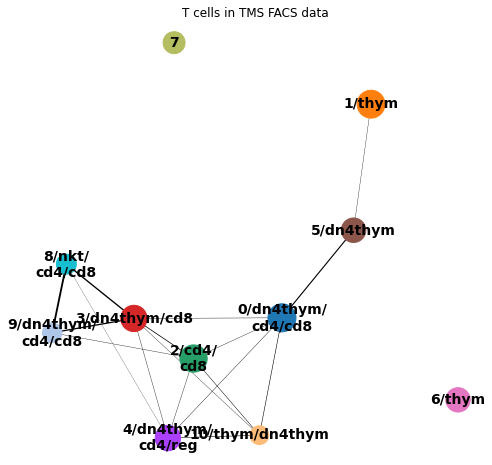

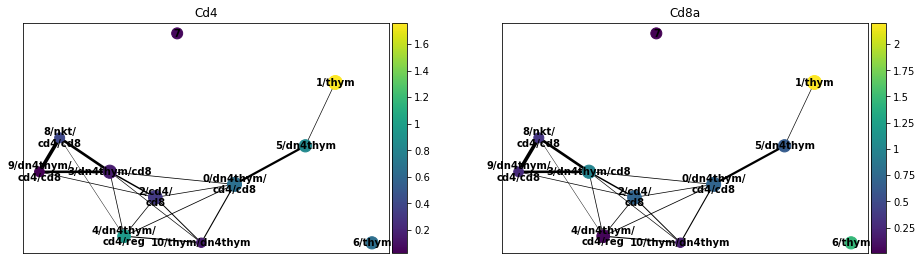

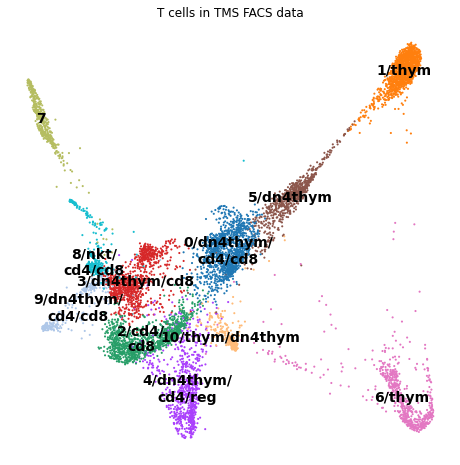

In [12]:
# Trajectory for facs data 
adata = dic_data_proc['facs'].copy()

adata.obs['leiden_anno'] = adata.obs['leiden']
adata.obs['leiden_anno'].cat.categories = ['0/dn4thym/\ncd4/cd8', '1/thym', '2/cd4/\ncd8', 
                                           '3/dn4thym/cd8', '4/dn4thym/\ncd4/reg', '5/dn4thym', 
                                           '6/thym', '7', '8/nkt/\ncd4/cd8',
                                           '9/dn4thym/\ncd4/cd8', '10/thym/dn4thym',
                                           '11/cd4', '12/cd4', '13', '14', '15/dn4thym', '16',
                                           '17', '18']
# Remove small clusters 
print('# Before filter: n_cell=%d'%adata.shape[0])
temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
cluster_list = temp_df.index[temp_df['cell']>200]
adata = adata[adata.obs['leiden'].isin(cluster_list)]
print('# After filter: n_cell=%d'%adata.shape[0])

# PAGA
sc.tl.paga(adata, groups='leiden_anno')
plt.figure(figsize=[8,8])
ax = plt.subplot(1,1,1)
ax.axis('off')
sc.pl.paga(adata, threshold=0.1, color=['leiden_anno'],
           edge_width_scale=0.25, node_size_scale=4, fontsize=14,
           title='T cells in TMS FACS data', ax=ax)
plt.show()

sc.pl.paga(adata, threshold=0.1, color=['Cd4', 'Cd8a'], edge_width_scale=0.5)

# draw_graph
sc.tl.draw_graph(adata, init_pos='paga')
plt.figure(figsize=[8,8])
ax = plt.subplot(1,1,1)
ax.axis('off')
sc.pl.draw_graph(adata, color=['leiden_anno'], legend_loc='on data',
                 legend_fontsize=14, title='T cells in TMS FACS data', ax=ax)
plt.show()

### Load score 

In [13]:
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs.gwas_max_abs_z.top500',
                  'droplet': DATA_PATH+'/score_file/score.tms_droplet.gwas_max_abs_z.top500.weight_1en2',
                  'facs_tsig': DATA_PATH+'/score_file/score.tms_facs.tcell_sig',
                  'droplet_tsig': DATA_PATH+'/score_file/score.tms_droplet.tcell_sig'}
SCORE_LIST = DIC_SCORE_PATH.keys()

dic_score = {x:pd.DataFrame() for x in SCORE_LIST}
dic_trait_list = {x:[] for x in SCORE_LIST}

for score in SCORE_LIST:
    print('# Loading %s score'%score)
    for file in [x for x in os.listdir(DIC_SCORE_PATH[score]) if '.score.gz' in x]:
        trait = file.replace('.score.gz','')
        dic_trait_list[score].append(trait)
        temp_df = pd.read_csv(join(DIC_SCORE_PATH[score],file), sep='\t', index_col=0)
        temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
        temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
        dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)

# Loading facs score
# Loading droplet score
# Loading facs_tsig score
# Loading droplet_tsig score


In [15]:
# Align traits 
trait_list = list(set(dic_trait_list['facs']) & set(dic_trait_list['droplet']))
print('# n_trait=%d'%len(trait_list))

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[ds].index))
    temp_df = dic_data_proc[ds].obs.loc[dic_cell_list[ds]].groupby('cell_ontology_class').agg({'cell':len})
    print(temp_df.loc[temp_df['cell']>0])

# n_trait=170
                                 cell
cell_ontology_class                  
CD4-positive, alpha-beta T cell  1170
CD8-positive, alpha-beta T cell  1070
DN4 thymocyte                    1756
T cell                           1329
mature NK T cell                  199
mature alpha-beta T cell          330
regulatory T cell                  47
thymocyte                        1625
                                  cell
cell_ontology_class                   
CD4-positive, alpha-beta T cell    551
CD8-positive, alpha-beta T cell    870
DN3 thymocyte                      146
DN4 thymocyte                     2000
T cell                           11416
double negative T cell             971
immature NKT cell                   84
immature T cell                   1784
mature NK T cell                  2962
naive T cell                      1568
regulatory T cell                  123
thymocyte                         1892


### Analysis: celltype-trait association

In [16]:
dic_trait_assoc_list = {x:[] for x in DS_LIST}

for ds in DS_LIST:
    print('# %s'%DIC_INFO[ds]['dname'])
    for trait in trait_list:
        
        temp_df = (dic_score[ds].loc[dic_cell_list[ds], ['%s.fdr'%trait]]<0.1)
        temp_df = temp_df.join(dic_data_proc[ds].obs[['cell_ontology_class']])
        temp_df = temp_df.groupby('cell_ontology_class').agg({'%s.fdr'%trait:np.mean})
        if (temp_df['%s.fdr'%trait]>0.1).sum()>1:
            print(trait)
            print(temp_df.loc[temp_df['%s.fdr'%trait]>0.1])
            dic_trait_assoc_list[ds].append(trait)

# TMS FACS
PASS_Multiple_sclerosis
                                 PASS_Multiple_sclerosis.fdr
cell_ontology_class                                         
CD4-positive, alpha-beta T cell                     0.129915
CD8-positive, alpha-beta T cell                     0.126168
T cell                                              0.124153
mature NK T cell                                    0.145729
mature alpha-beta T cell                            0.178788
regulatory T cell                                   0.170213
UKB_460K.disease_RESPIRATORY_ENT
                     UKB_460K.disease_RESPIRATORY_ENT.fdr
cell_ontology_class                                      
T cell                                           0.104590
regulatory T cell                                0.148936
PASS_Rheumatoid_Arthritis
                                 PASS_Rheumatoid_Arthritis.fdr
cell_ontology_class                                           
CD4-positive, alpha-beta T cell                       0.1188

UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
                                 UKB_460K.disease_HYPOTHYROIDISM_SELF_REP.fdr
cell_ontology_class                                                          
CD4-positive, alpha-beta T cell                                      0.375681
CD8-positive, alpha-beta T cell                                      0.221839
DN4 thymocyte                                                        0.236000
T cell                                                               0.340137
double negative T cell                                               0.222451
immature NKT cell                                                    0.297619
mature NK T cell                                                     0.215057
regulatory T cell                                                    0.739837


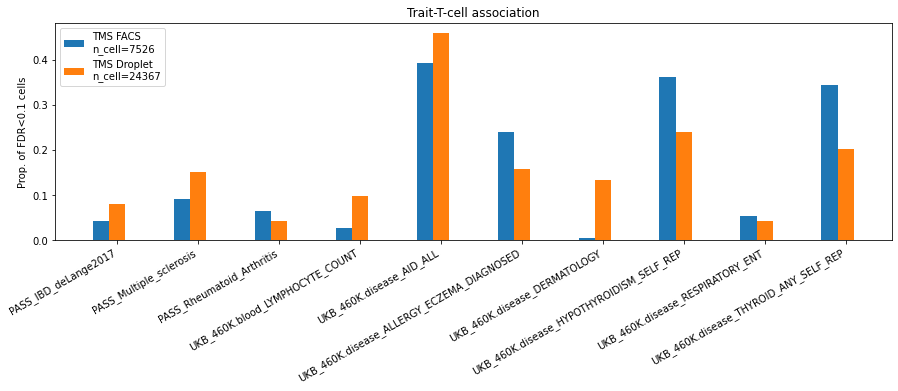

In [17]:
# Overall association pattern
trait_list_plot = sorted(list(set(dic_trait_assoc_list['facs']) | 
                              set(dic_trait_assoc_list['droplet'])))
df_plot = pd.DataFrame(index=trait_list_plot, columns=['facs', 'droplet'])
dic_n_cell = {}
for trait in trait_list_plot:
    
    cell_list = dic_cell_list['facs']
    dic_n_cell['facs'] = len(cell_list)
    df_plot.loc[trait, 'facs'] = (dic_score['facs'].loc[cell_list, '%s.fdr'%trait]<0.1).mean()
    
    cell_list = dic_cell_list['droplet']
    dic_n_cell['droplet'] = len(cell_list)
    df_plot.loc[trait, 'droplet'] = (dic_score['droplet'].loc[cell_list, '%s.fdr'%trait]<0.1).mean()
df_plot['loc'] = range(df_plot.shape[0])

plt.figure(figsize=[15,4])
plt.bar(df_plot['loc']-0.2, df_plot['facs'], width=0.2, label='TMS FACS\nn_cell=%d'%dic_n_cell['facs'])
plt.bar(df_plot['loc'], df_plot['droplet'], width=0.2, label='TMS Droplet\nn_cell=%d'%dic_n_cell['droplet'])
plt.xticks(df_plot['loc'], df_plot.index, ha='right', rotation=30)
plt.ylabel('Prop. of FDR<0.1 cells')
plt.legend()
plt.title('Trait-T-cell association')
plt.show()

### Heterogeneity pattern 

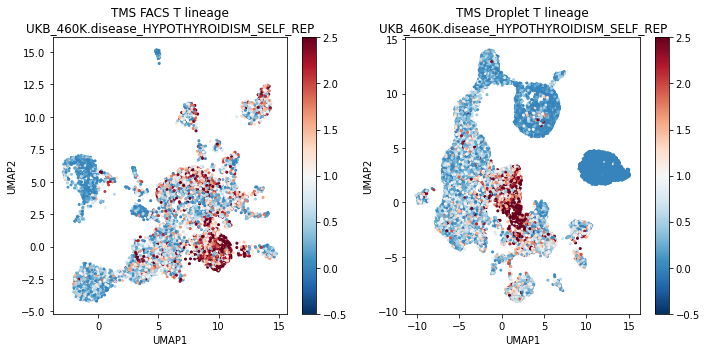

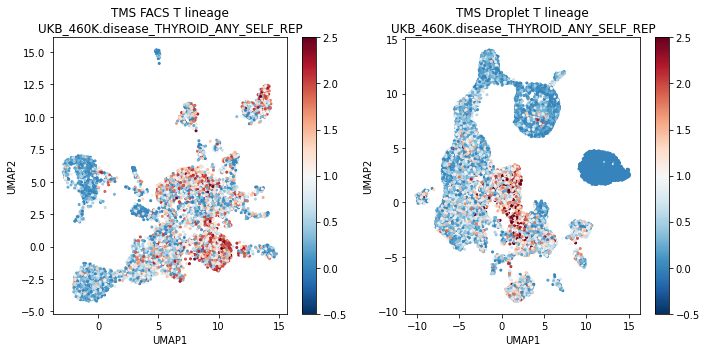

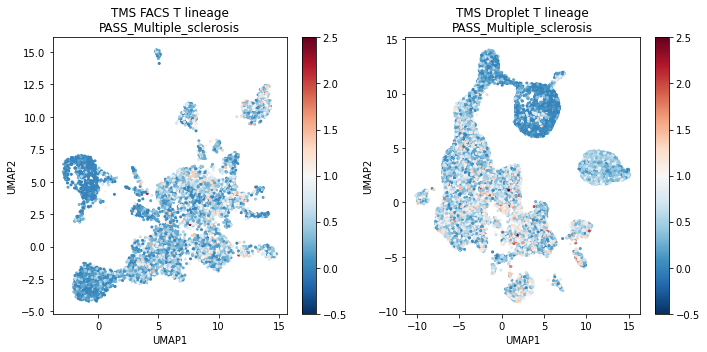

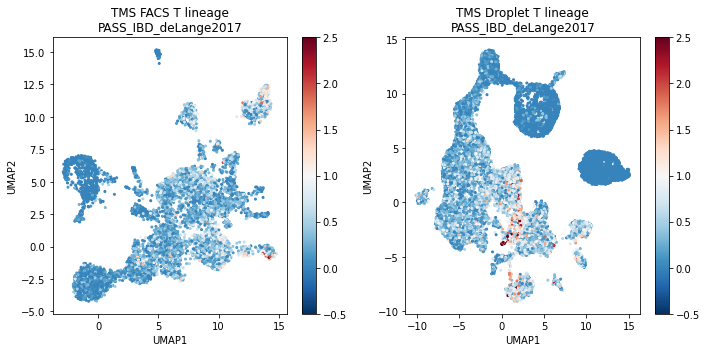

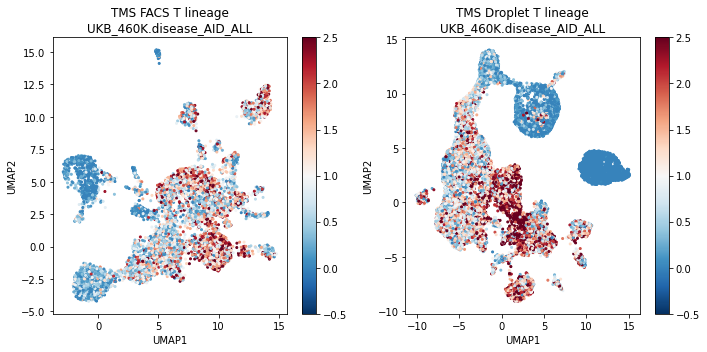

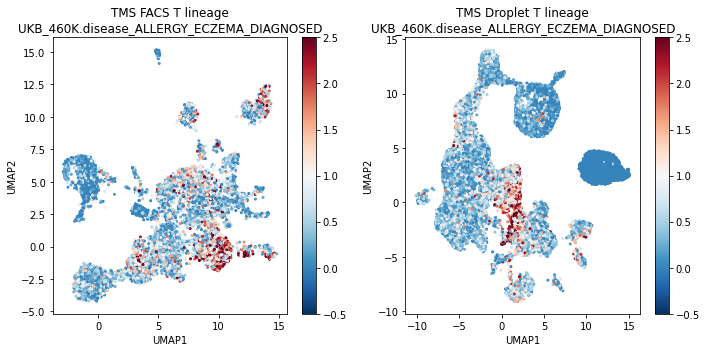

In [18]:
# Todo: add a p-value to quantify the similarity
trait_list_plot = list(set(dic_trait_assoc_list['facs']) & 
                       set(dic_trait_assoc_list['droplet']))

for trait in trait_list_plot:
    plt.figure(figsize=[10,5])
    for i_ds,ds in enumerate(DS_LIST):
        
        df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                               data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                     'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
        df_plot = df_plot.loc[dic_cell_list[ds]]
        df_plot = df_plot.join(dic_score[ds]['%s.fdr'%trait])
        df_plot['%s.nlog10_fdr'%trait] = -np.log10(df_plot['%s.fdr'%trait])
        
        plt.subplot(1,2,i_ds+1)
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_fdr'%trait],
                    cmap='RdBu_r', vmax=2.5, vmin=-0.5, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s T lineage\n%s'%(DIC_INFO[ds]['dname'], trait))
    
    plt.tight_layout()
    plt.show()

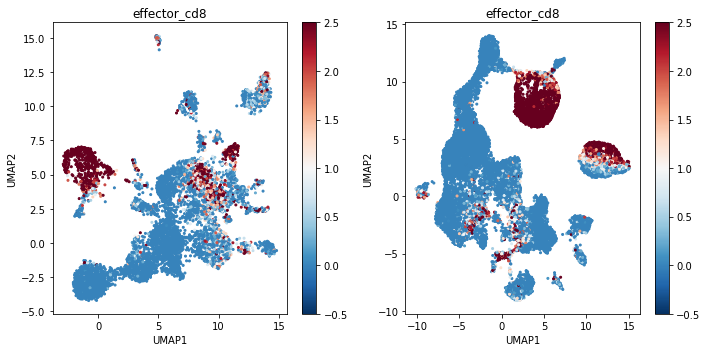

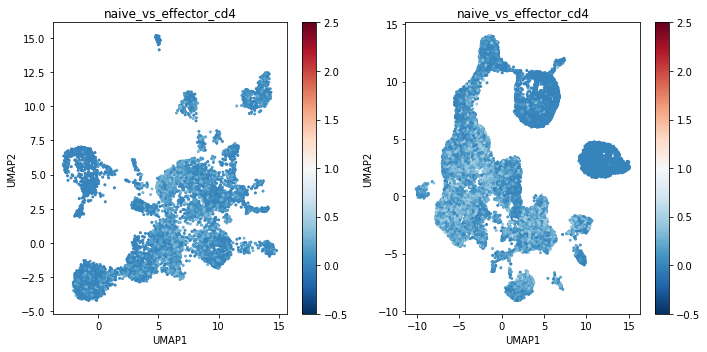

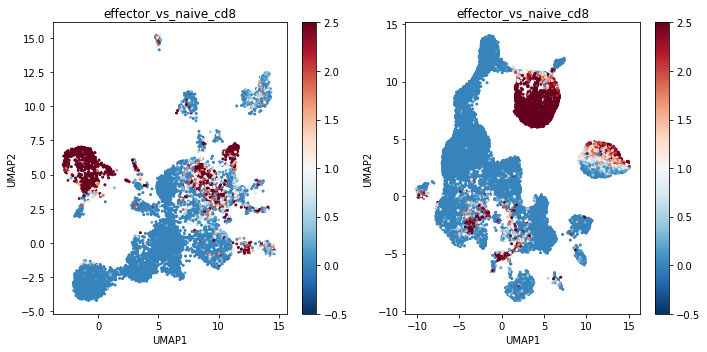

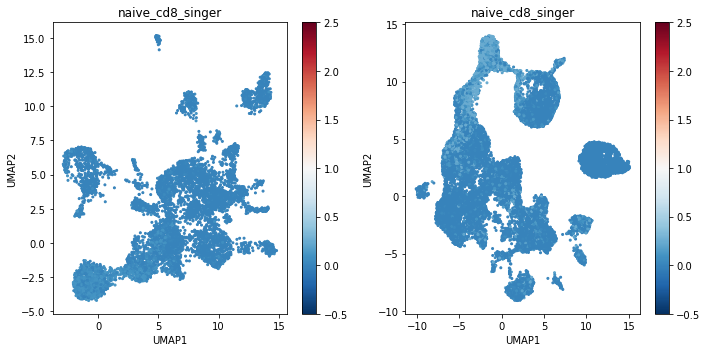

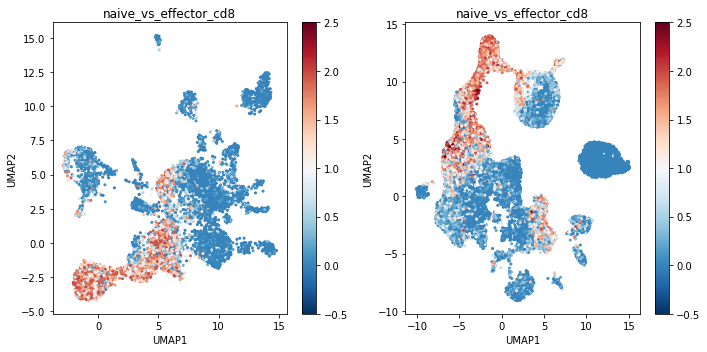

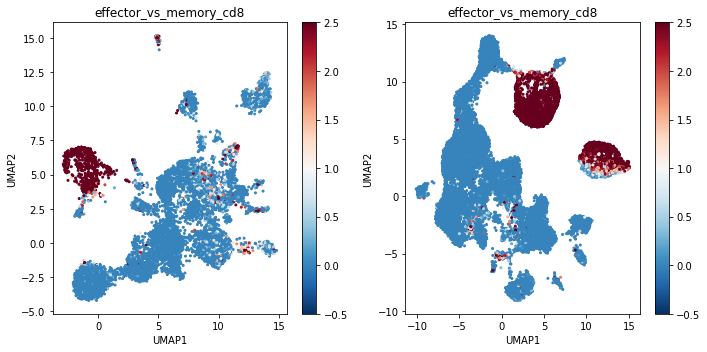

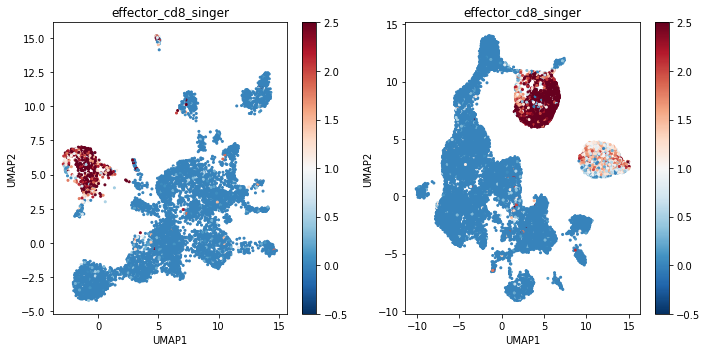

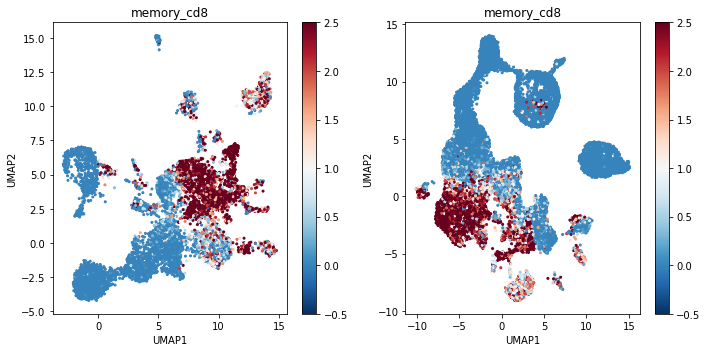

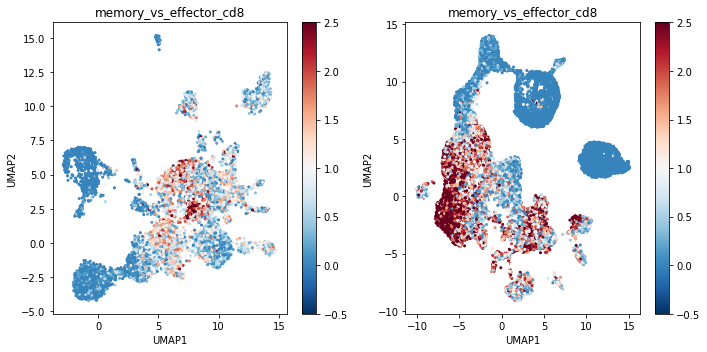

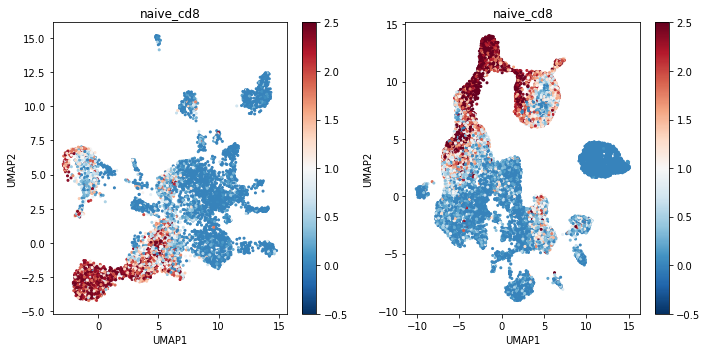

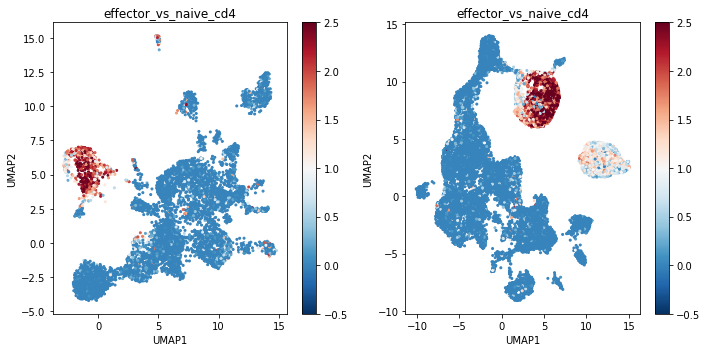

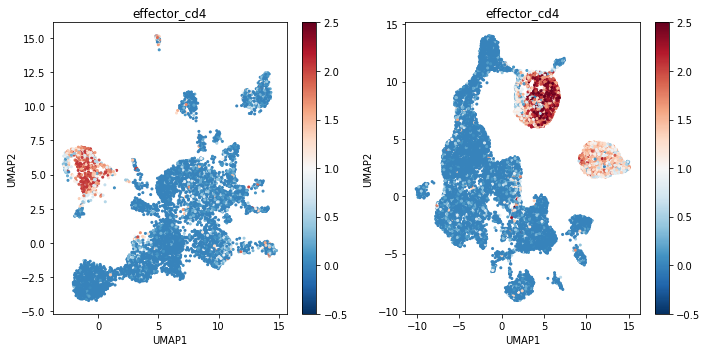

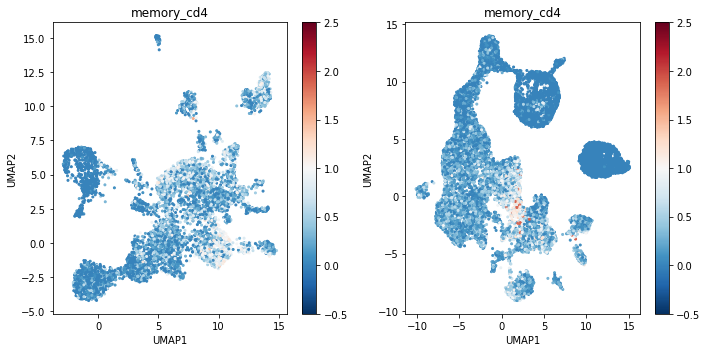

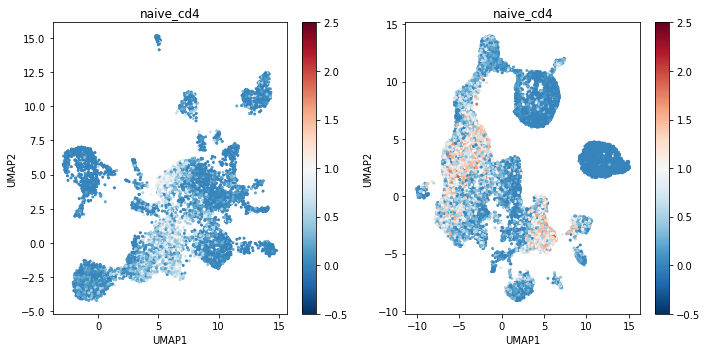

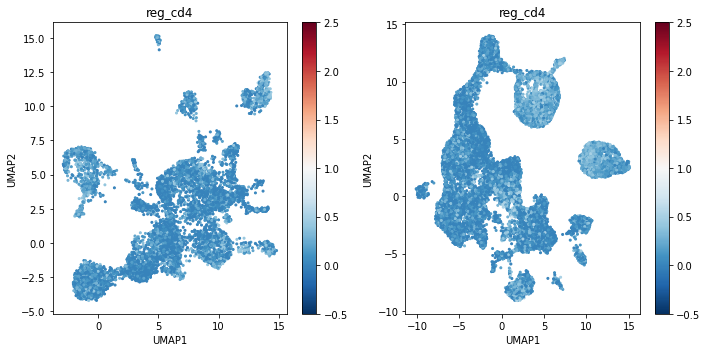

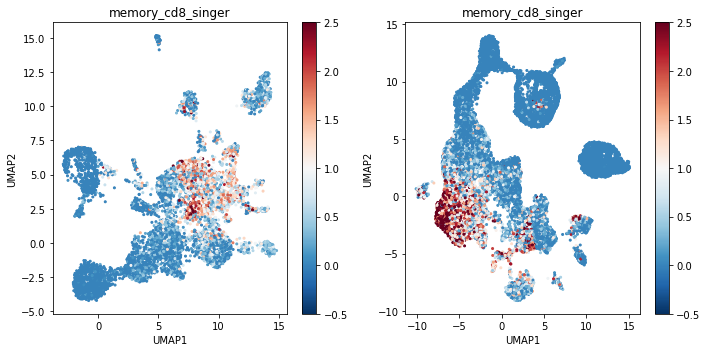

In [19]:
for trait in dic_trait_list['facs_tsig']:
    plt.figure(figsize=[10,5])
    for i_score,score in enumerate(['facs_tsig', 'droplet_tsig']):
        
        ds = score.split('_')[0]        
        df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                               data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                     'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
        df_plot = df_plot.loc[dic_cell_list[ds]]
        df_plot = df_plot.join(dic_score[score]['%s.fdr'%trait])
        df_plot['%s.nlog10_fdr'%trait] = -np.log10(df_plot['%s.fdr'%trait])
        
        plt.subplot(1,2,i_score+1)
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_fdr'%trait],
                    cmap='RdBu_r', vmax=2.5, vmin=-0.5, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title(trait)
    
    plt.tight_layout()
    plt.show()

### Trajectory analysis

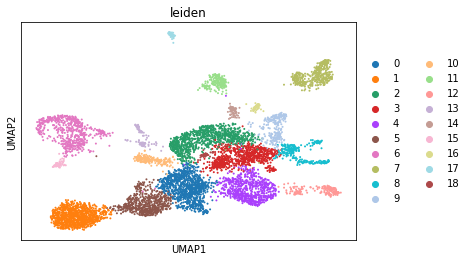

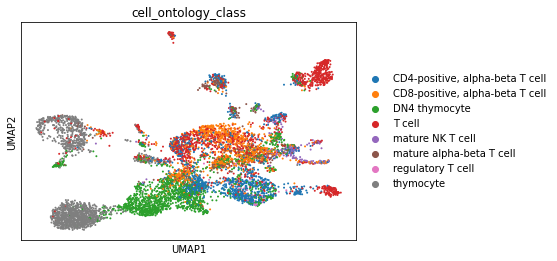

cell
leiden cell_ontology_class                   
0      CD4-positive, alpha-beta T cell  228.0
       CD8-positive, alpha-beta T cell  143.0
       DN4 thymocyte                    613.0
       T cell                            28.0
       mature alpha-beta T cell          23.0
1      DN4 thymocyte                     40.0
       thymocyte                        970.0
2      CD4-positive, alpha-beta T cell  158.0
       CD8-positive, alpha-beta T cell  409.0
       T cell                           359.0
3      CD4-positive, alpha-beta T cell   24.0
       CD8-positive, alpha-beta T cell  356.0
       DN4 thymocyte                    155.0
       T cell                           113.0
       mature NK T cell                  24.0
       mature alpha-beta T cell         128.0
4      CD4-positive, alpha-beta T cell  457.0
       DN4 thymocyte                    120.0
       T cell                            62.0
       regulatory T cell                 40.0
5      DN4 thymocyte                    571.0
6      T cell                            45.0
       thymocyte                        509.0
7      DN4 thymocyte                     26.0
       T cell                           339.0
8      CD4-positive, alpha-beta T cell   37.0
       CD8-positive, alpha-beta T cell   46.0
       T cell                            34.0
       mature NK T cell                 114.0
9      CD4-positive, alpha-beta T cell   61.0
       CD8-positive, alpha-beta T cell   29.0
       DN4 thymocyte                     60.0
       T cell                            50.0
       mature NK T cell                  38.0
10     DN4 thymocyte                     27.0
       T cell                            39.0
       thymocyte                        103.0
11     CD4-positive, alpha-beta T cell   66.0
       T cell                            32.0
       mature alpha-beta T cell          76.0
12     CD4-positive, alpha-beta T cell   54.0
       T cell                           116.0
13     T cell                            42.0
14     mature alpha-beta T cell          34.0
15     DN4 thymocyte                     50.0
17     T cell                            41.0

In [59]:
# facs
adata = dic_data_proc['facs'].copy()
sc.pl.umap(adata, color='leiden')
sc.pl.umap(adata, color='cell_ontology_class')
temp_df = adata.obs.groupby(['leiden', 'cell_ontology_class']).agg({'cell':len})
temp_df.loc[temp_df['cell']>20]

# Before filter: n_cell=7526
# After filter: n_cell=5539


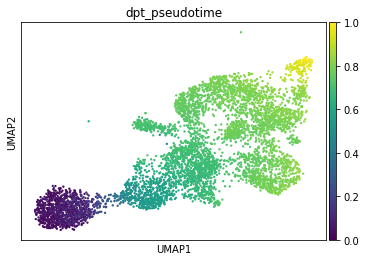

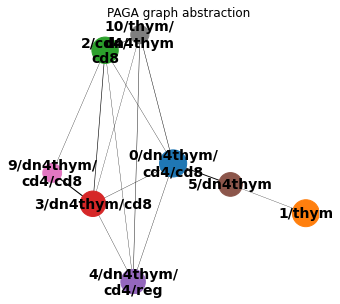

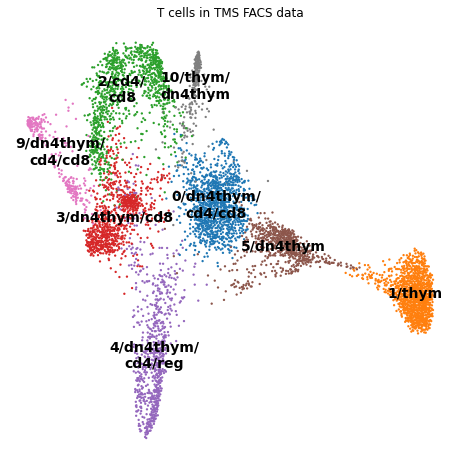

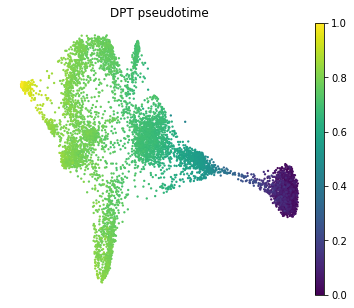

In [64]:
# Trajectory for facs data 
adata = dic_data_proc['facs'].copy()

adata.obs['leiden_anno'] = adata.obs['leiden']
adata.obs['leiden_anno'].cat.categories = ['0/dn4thym/\ncd4/cd8', '1/thym', '2/cd4/\ncd8', 
                                           '3/dn4thym/cd8', '4/dn4thym/\ncd4/reg', '5/dn4thym', 
                                           '6/thym', '7', '8/nkt/\ncd4/cd8',
                                           '9/dn4thym/\ncd4/cd8', '10/thym/\ndn4thym',
                                           '11/cd4', '12/cd4', '13', '14', '15/dn4thym', '16',
                                           '17', '18']
# Remove small clusters 
print('# Before filter: n_cell=%d'%adata.shape[0])
temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
cluster_list = list(temp_df.index[temp_df['cell']>200])
cluster_list.remove('6')
cluster_list.remove('7')
cluster_list.remove('8')
adata = adata[adata.obs['leiden'].isin(cluster_list)]
print('# After filter: n_cell=%d'%adata.shape[0])

sc.tl.diffmap(adata)
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '1')[0]
sc.tl.dpt(adata)
sc.pl.umap(adata, color='dpt_pseudotime')

# PAGA
sc.tl.paga(adata, groups='leiden_anno')
plt.figure(figsize=[5,5])
ax = plt.subplot(1,1,1)
ax.axis('off')
sc.pl.paga(adata, threshold=0.1, color=['leiden_anno'],
           edge_width_scale=0.25, node_size_scale=4, fontsize=14,
           title='PAGA graph abstraction', ax=ax)
plt.show()

# draw_graph
sc.tl.draw_graph(adata, init_pos='paga')
plt.figure(figsize=[8,8])
ax = plt.subplot(1,1,1)
ax.axis('off')
sc.pl.draw_graph(adata, color=['leiden_anno'], legend_loc='on data',
                 legend_fontsize=14, title='T cells in TMS FACS data', ax=ax)
plt.show()

plt.figure(figsize=[6,5])
ax = plt.subplot(1,1,1)
ax.axis('off')
fig=sc.pl.draw_graph(adata, color=['dpt_pseudotime'], legend_loc='on data',
                 legend_fontsize=14, title='DPT pseudotime', ax=ax)
plt.show()

dic_data_traj = {}
dic_data_traj['facs'] = adata.copy()

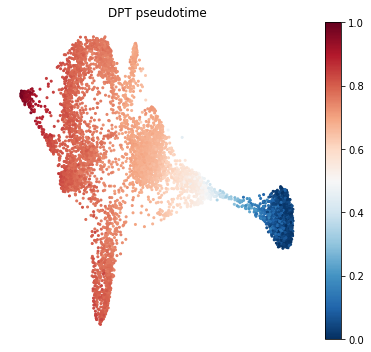

In [65]:
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_draw_graph_fa'][:,0],
                             'UMAP2':adata.obsm['X_draw_graph_fa'][:,1]})
df_plot = df_plot.join(adata.obs['dpt_pseudotime'])

plt.figure(figsize=[5.5,5])
ax = plt.subplot(1,1,1)
ax.axis('off')
plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['dpt_pseudotime'],
            cmap='RdBu_r', vmax=1, vmin=0, s=4)
plt.colorbar()
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('DPT pseudotime')

plt.tight_layout()
plt.show()

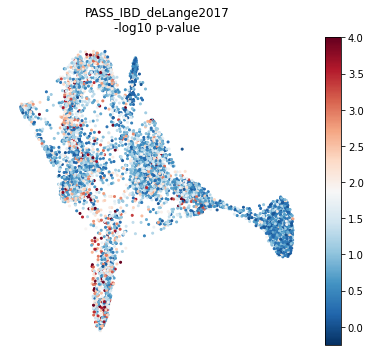

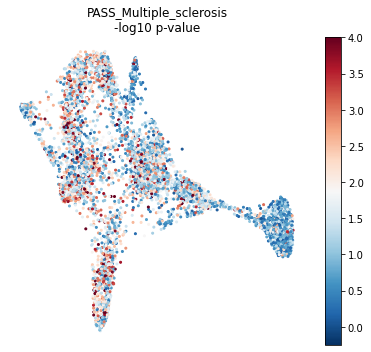

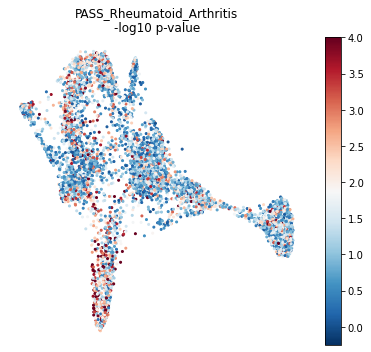

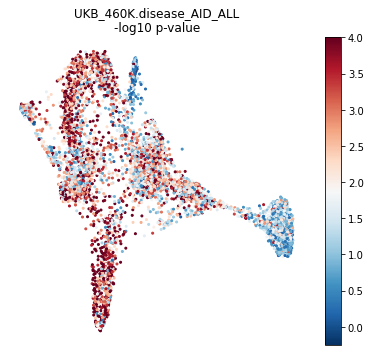

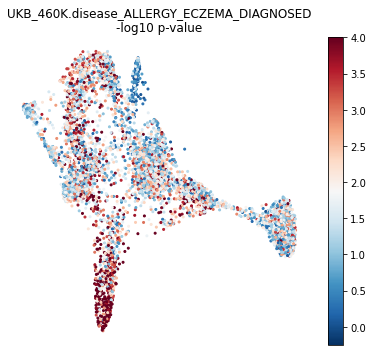

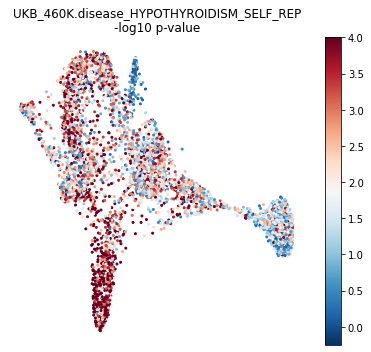

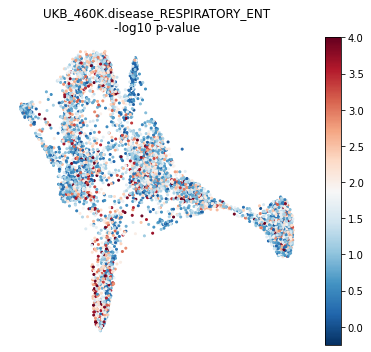

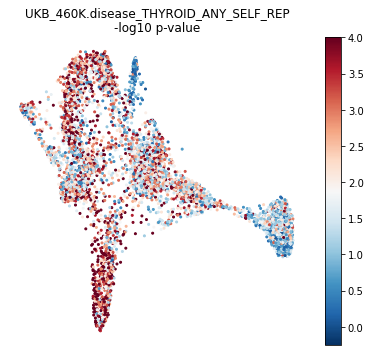

In [68]:
adata = dic_data_traj['facs'].copy()
trait_list_plot = sorted(dic_trait_assoc_list['facs'])
ds='facs'

for trait in trait_list_plot:
    
    df_plot = pd.DataFrame(index=adata.obs_names,
                           data={'UMAP1':adata.obsm['X_draw_graph_fa'][:,0],
                                 'UMAP2':adata.obsm['X_draw_graph_fa'][:,1]})
    df_plot = df_plot.join(dic_score[ds]['%s.pval'%trait])
    df_plot['%s.nlog10_pval'%trait] = -np.log10(df_plot['%s.pval'%trait])

    plt.figure(figsize=[5.5,5])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_pval'%trait],
                cmap='RdBu_r', vmax=4, vmin=-0.25, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s\n-log10 p-value'%trait)
    
    plt.tight_layout()
    plt.show()

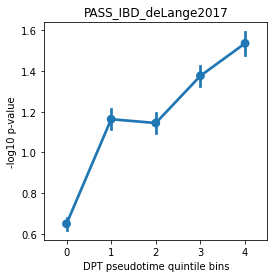

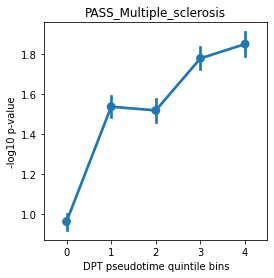

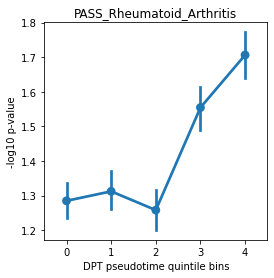

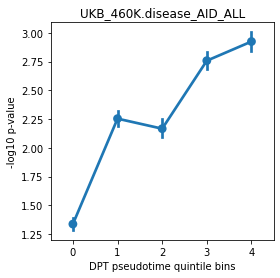

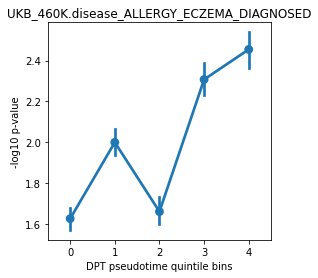

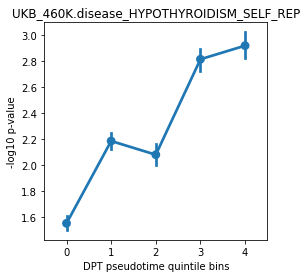

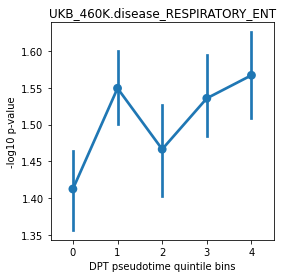

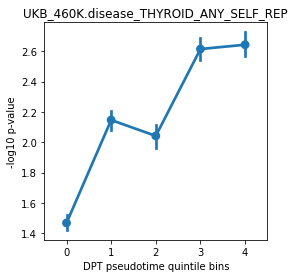

In [70]:
adata = dic_data_traj['facs'].copy()
trait_list_plot = sorted(dic_trait_assoc_list['facs'])
ds = 'facs'

for i_trait,trait in enumerate(trait_list_plot):
    
    df_plot = adata.obs[['dpt_pseudotime']].copy()
    df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, '%s.pval'%trait])
    df_plot['nlog_pval'] = - np.log10(df_plot['%s.pval'%trait])
    df_plot['bin'] = pd.qcut(df_plot['dpt_pseudotime'], q=5, labels=False)
    
    plt.figure(figsize=[4, 4])
    sns.pointplot(data=df_plot, x='bin', y='nlog_pval')
    plt.title(trait)
    plt.xlabel('DPT pseudotime quintile bins')
    plt.ylabel('-log10 p-value')
    plt.show()

/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


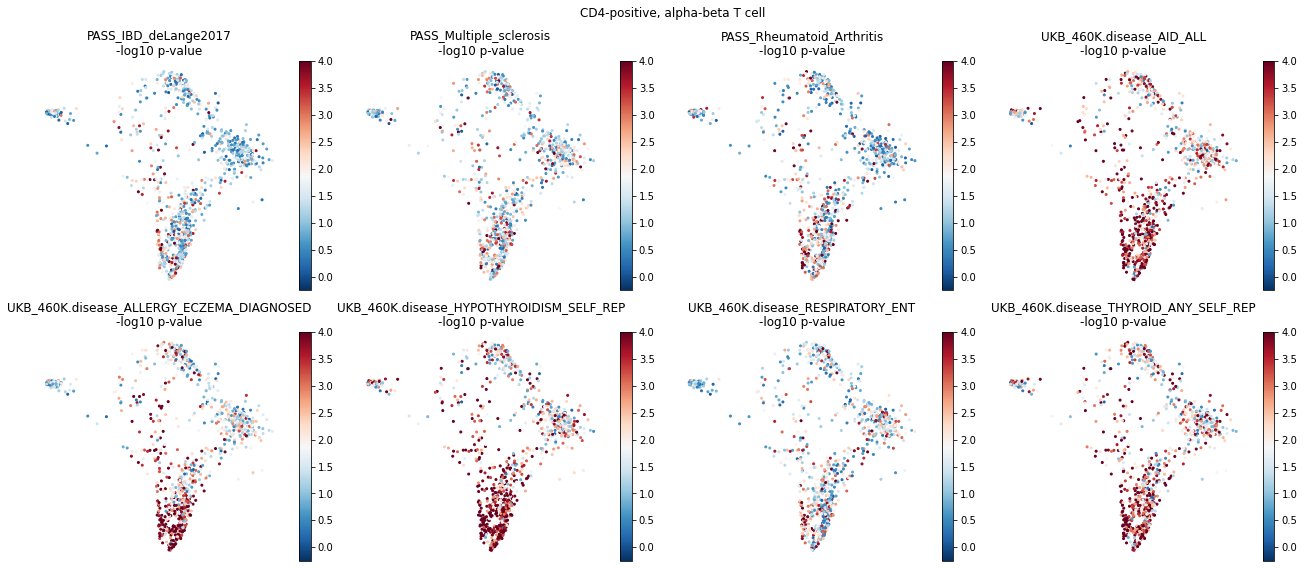

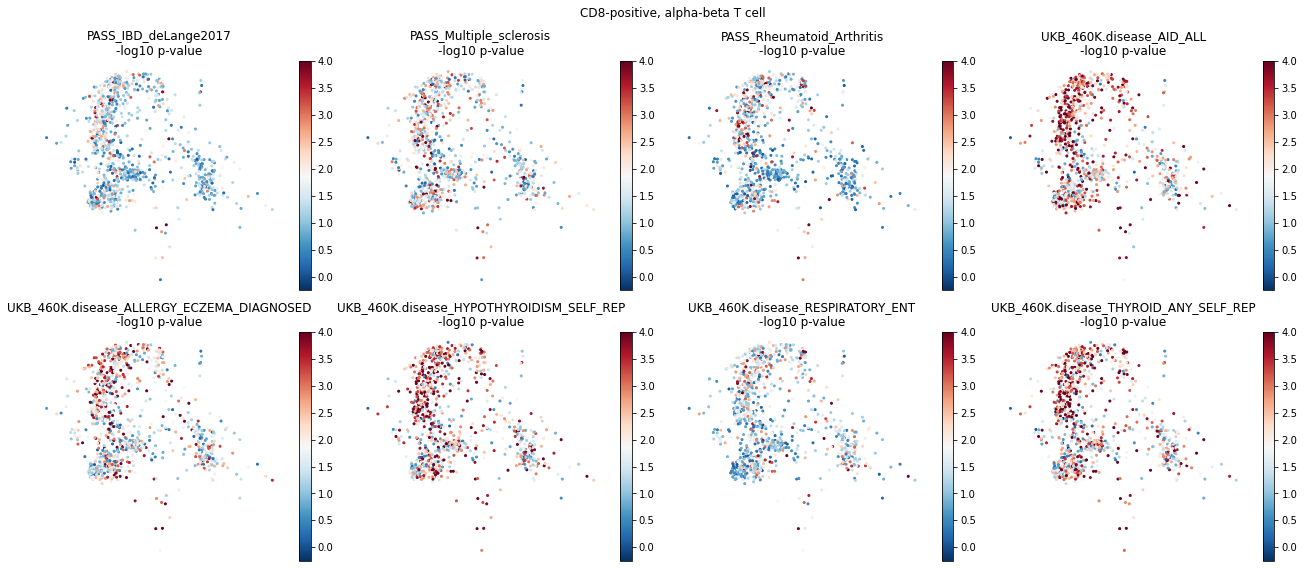

In [71]:
adata = dic_data_traj['facs'].copy()
trait_list_plot = sorted(dic_trait_assoc_list['facs'])
ds='facs'

for celltype in ['CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell']:
    plt.figure(figsize=[18, 8])
    for i_trait,trait in enumerate(trait_list_plot):
        
        plt.subplot(2,4,i_trait+1)
        df_plot = pd.DataFrame(index=adata.obs_names,
                               data={'UMAP1':adata.obsm['X_draw_graph_fa'][:,0],
                                     'UMAP2':adata.obsm['X_draw_graph_fa'][:,1]})
        df_plot = df_plot.join(adata.obs[['cell_ontology_class']])
        df_plot = df_plot.loc[df_plot['cell_ontology_class']==celltype]
        df_plot = df_plot.join(dic_score[ds]['%s.pval'%trait])
        df_plot['%s.nlog10_pval'%trait] = -np.log10(df_plot['%s.pval'%trait])

        ax = plt.subplot(2,4,i_trait+1)
        ax.axis('off')
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_pval'%trait],
                    cmap='RdBu_r', vmax=4, vmin=-0.25, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s\n-log10 p-value'%trait)
    
    plt.suptitle(celltype)
    plt.tight_layout()
    plt.show()

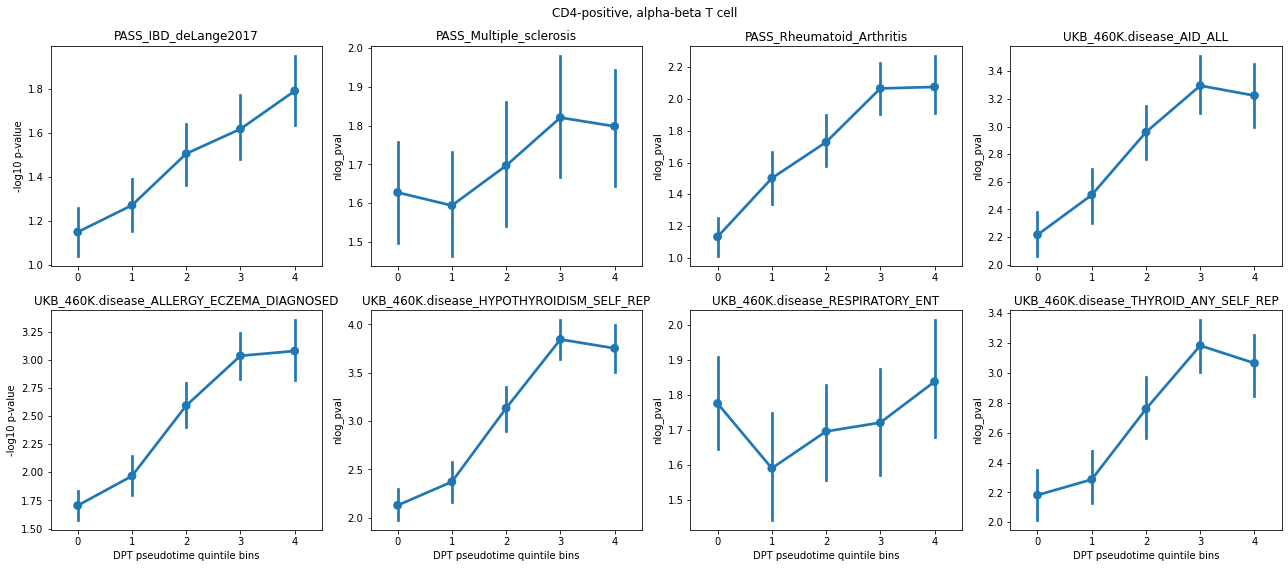

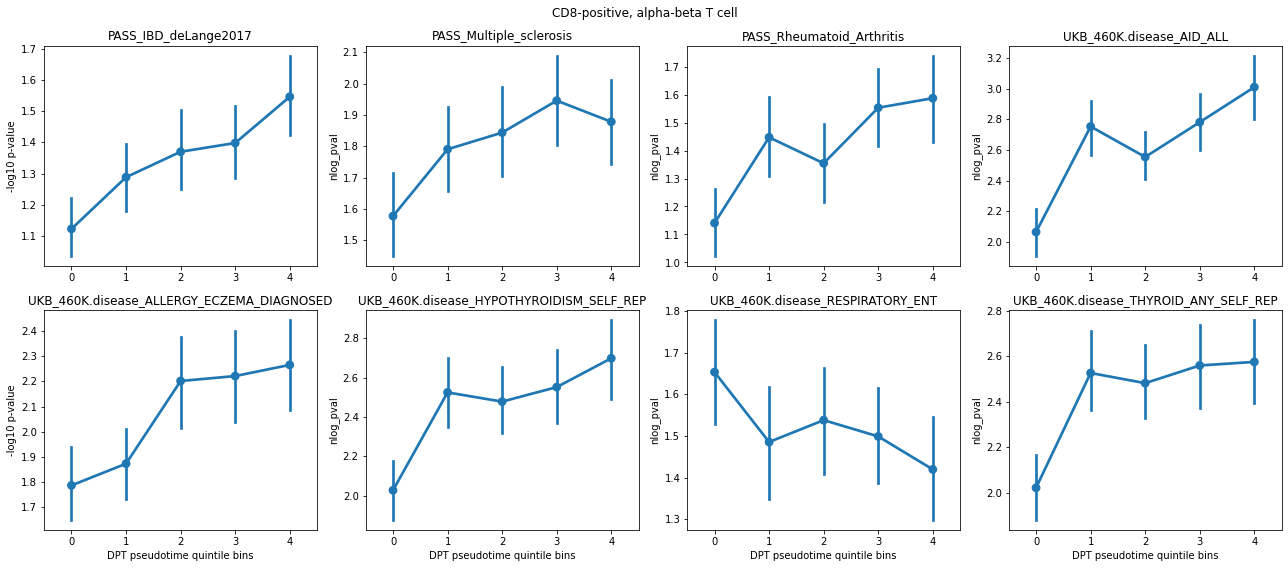

In [72]:
adata = dic_data_traj['facs'].copy()
trait_list_plot = sorted(dic_trait_assoc_list['facs'])
ds = 'facs'
for celltype in ['CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell']:
    plt.figure(figsize=[18, 8])
    for i_trait,trait in enumerate(trait_list_plot):

        plt.subplot(2,4,i_trait+1)
        df_plot = adata.obs[['dpt_pseudotime', 'cell_ontology_class']].copy()
        df_plot = df_plot.loc[df_plot['cell_ontology_class']==celltype]
        df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, '%s.pval'%trait])
        df_plot['nlog_pval'] = - np.log10(df_plot['%s.pval'%trait])
        df_plot['bin'] = pd.qcut(df_plot['dpt_pseudotime'], q=5, labels=False)
        
        sns.pointplot(data=df_plot, x='bin', y='nlog_pval')
        plt.title(trait)
        if i_trait>3:
            plt.xlabel('DPT pseudotime quintile bins')
        else:
            plt.xlabel('')
        if i_trait%4==0:
            plt.ylabel('-log10 p-value')
        
    plt.suptitle(celltype)
    plt.tight_layout()
    plt.show()

### Lineage-dependant progression

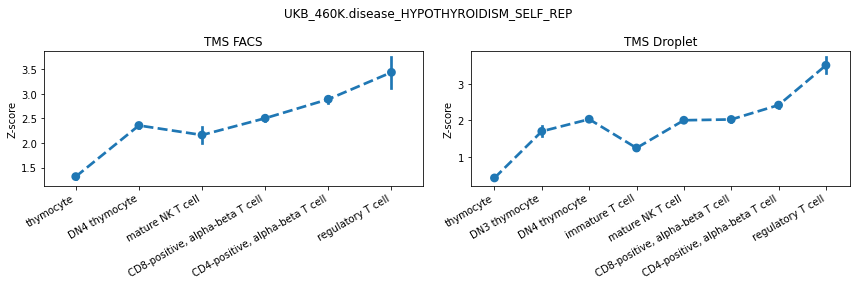

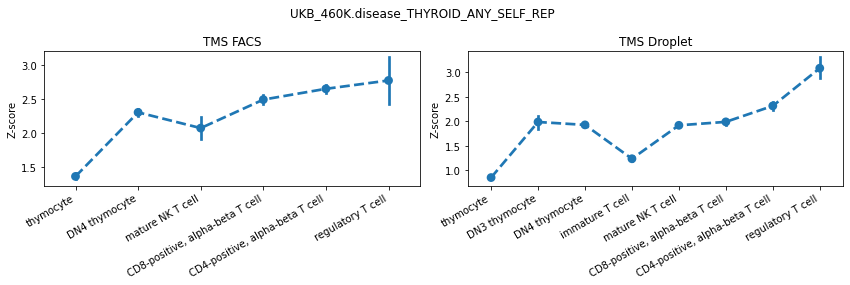

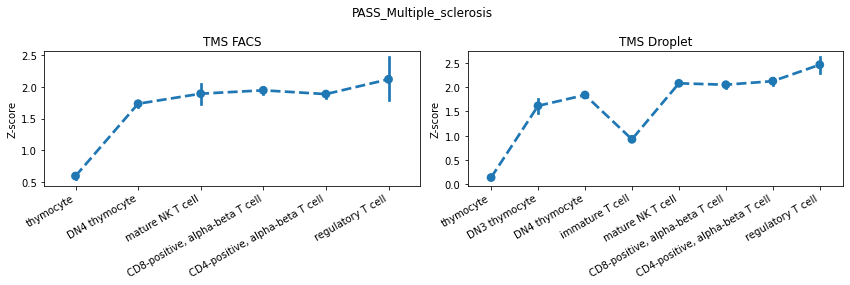

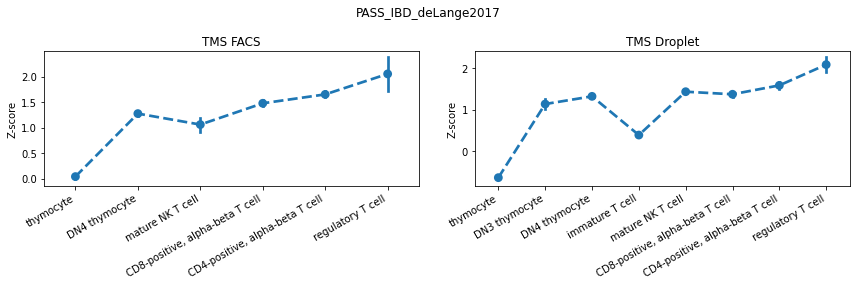

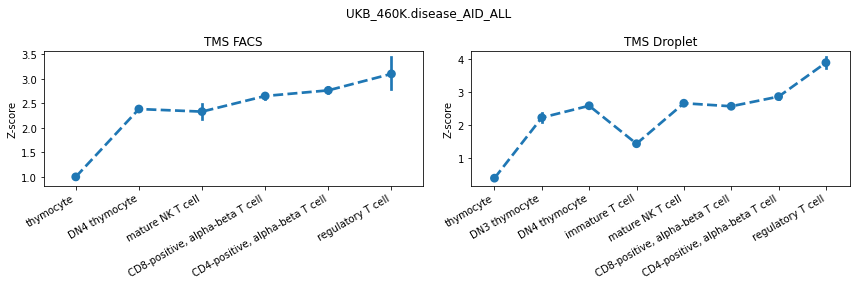

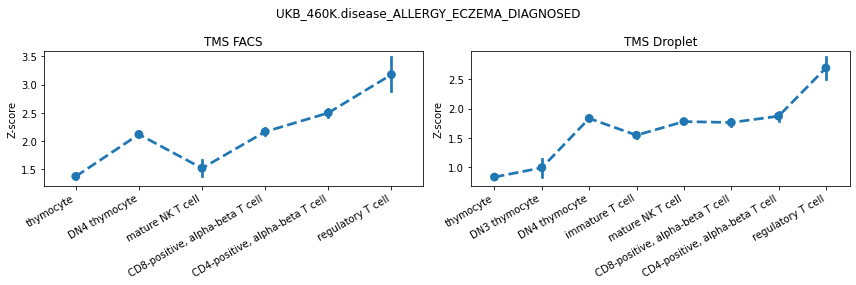

In [47]:
trait_list_plot = list(set(dic_trait_assoc_list['facs']) & 
                       set(dic_trait_assoc_list['droplet']))
celltype_list = ['thymocyte', 'DN3 thymocyte', 'DN4 thymocyte', 
                 'immature T cell', 'immature NKT cell'
                 'mature alpha-beta T cell', 'mature NK T cell',
                 'CD8-positive, alpha-beta T cell',
                 'CD4-positive, alpha-beta T cell', 'regulatory T cell']

for trait in trait_list_plot:
    plt.figure(figsize=[12,4])
    for i_ds,ds in enumerate(DS_LIST):
        
        df_plot = dic_score[ds][['%s.zscore'%trait]]
        df_plot = df_plot.join(dic_data_proc[ds].obs[['cell_ontology_class']])
        celltype_list_ds = [x for x in celltype_list if x in set(df_plot['cell_ontology_class'])]
        
        plt.subplot(1,2,i_ds+1)
        sns.pointplot(data=df_plot, x='cell_ontology_class', y='%s.zscore'%trait, 
                      linestyles='--', order=celltype_list_ds)
        plt.xticks(range(len(celltype_list_ds)), celltype_list_ds, rotation=30, ha='right')
        plt.ylabel('Z-score')
        plt.xlabel('')
        plt.title(DIC_INFO[ds]['dname'])
    plt.suptitle(trait)
    plt.tight_layout()
    plt.show()

### Pathway

In [48]:
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                             'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}

In [50]:
from gprofiler import GProfiler
df_gs = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs',
                    sep='\t', index_col=0)

dic_pathway = {}
trait_list_plot = list(set(dic_trait_assoc_list['facs']) & set(dic_trait_assoc_list['droplet']))

for trait in trait_list_plot:
    
    # GWAS gene set
    gwas_gene_list = [dic_map[x] for x in df_gs.loc[trait, 'GENESET'].split(',') if x in dic_map.keys()]
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=gwas_gene_list,
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(dic_data_raw[ds].var_names))
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & \
                    (df_pathway['intersection_size']>10)
    dic_pathway['%s.gs'%(trait)] = df_pathway.loc[ind_select].copy()
    print('%s n_gwas_gene=%d'%(trait, len(gwas_gene_list)))
        
    for i_ds,ds in enumerate(DS_LIST):
    
        adata_small = dic_data_raw[ds][dic_cell_list[ds], :].copy()
        adata_small.obs['n_gene'] = (adata_small.X>0).sum(axis=1)
        adata_small.obs['fdr'] = (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait])
        adata_small.obs['group'] = 'other'
        adata_small.obs.loc[adata_small.obs['fdr']<0.1, 'group'] = 'assoc'
        adata_small.obs.loc[adata_small.obs['fdr']>0.5, 'group'] = 'non-assoc'
        adata_small = adata_small[adata_small.obs.group.isin(['assoc', 'non-assoc']), :]
        adata_small.obs['group'] = adata_small.obs['group'].astype('category')
        sc.tl.rank_genes_groups(adata_small, groupby='group', method='t-test_overestim_var', n_genes=200)
        
        assoc_gene_list = list(adata_small.uns['rank_genes_groups']['names']['assoc'])
        non_assoc_gene_list = list(adata_small.uns['rank_genes_groups']['names']['non-assoc'])
        print('# %s, overlap with gwas_gene_list=%d/%d'
              %(ds, len(set(gwas_gene_list) & set(assoc_gene_list)), len(assoc_gene_list)))

        gp = GProfiler(return_dataframe=True)
        df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                                query=list(adata_small.uns['rank_genes_groups']['names']['assoc']),
                                sources=['KEGG', 'GO:BP', 'REAC'],
                                significance_threshold_method='fdr', 
                                user_threshold=0.01,
                                background=list(dic_data_raw[ds].var_names))
        ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & \
                        (df_pathway['intersection_size']>10)
        dic_pathway['%s.%s.assoc'%(ds, trait)] = df_pathway.loc[ind_select].copy()

        gp = GProfiler(return_dataframe=True)
        df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                                query=list(adata_small.uns['rank_genes_groups']['names']['non-assoc']),
                                sources=['KEGG', 'GO:BP', 'REAC'],
                                significance_threshold_method='fdr', 
                                user_threshold=0.01,
                                background=list(dic_data_raw[ds].var_names))
        ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & \
                        (df_pathway['intersection_size']>10)
        dic_pathway['%s.%s.non-assoc'%(ds, trait)] = df_pathway.loc[ind_select].copy()
        
for term in dic_pathway.keys():
    dic_pathway[term].index = ['%s.%s'%(x,y) for x,y in zip(dic_pathway[term]['source'], dic_pathway[term]['name'])]

UKB_460K.disease_HYPOTHYROIDISM_SELF_REP n_gwas_gene=449


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# facs, overlap with gwas_gene_list=36/200


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# droplet, overlap with gwas_gene_list=32/200
UKB_460K.disease_THYROID_ANY_SELF_REP n_gwas_gene=441


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# facs, overlap with gwas_gene_list=38/200


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# droplet, overlap with gwas_gene_list=36/200
PASS_Multiple_sclerosis n_gwas_gene=450


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# facs, overlap with gwas_gene_list=42/200


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# droplet, overlap with gwas_gene_list=39/200
PASS_IBD_deLange2017 n_gwas_gene=436


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# facs, overlap with gwas_gene_list=27/200


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# droplet, overlap with gwas_gene_list=29/200
UKB_460K.disease_AID_ALL n_gwas_gene=449


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# facs, overlap with gwas_gene_list=41/200


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# droplet, overlap with gwas_gene_list=35/200
UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED n_gwas_gene=437


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# facs, overlap with gwas_gene_list=33/200


Trying to set attribute `.obs` of view, copying.
... storing 'tissue_celltype' as categorical


# droplet, overlap with gwas_gene_list=36/200


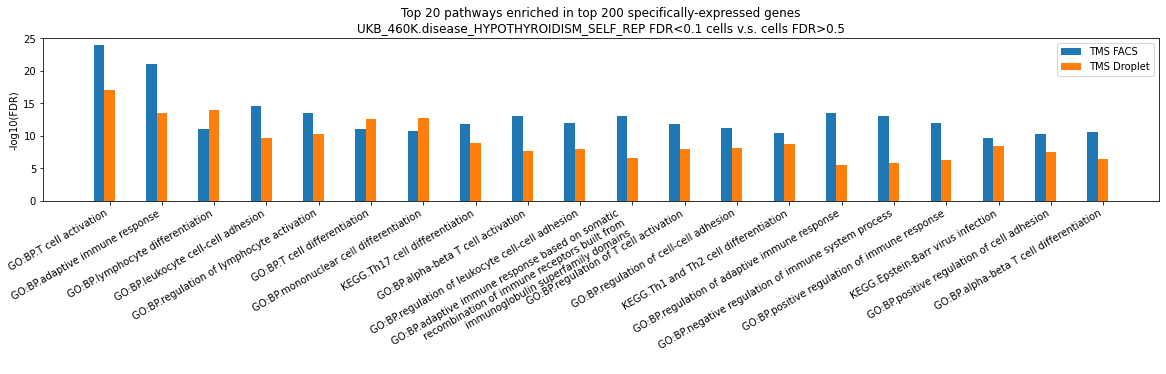

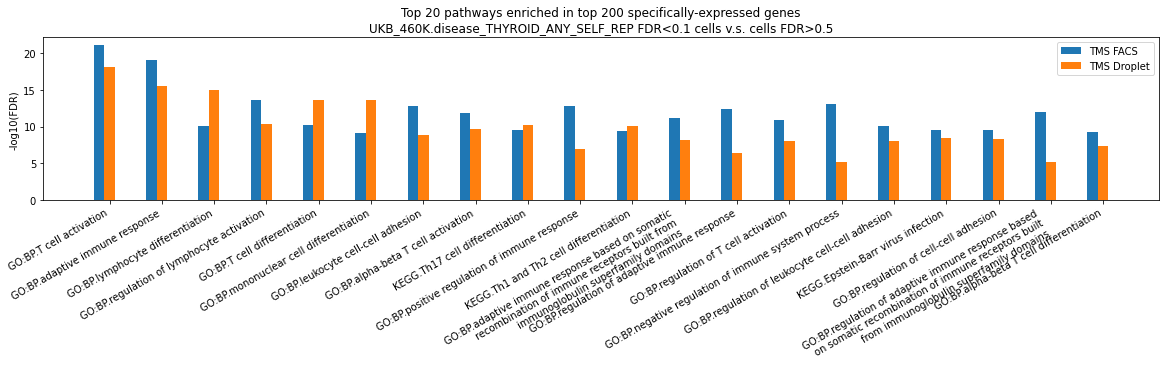

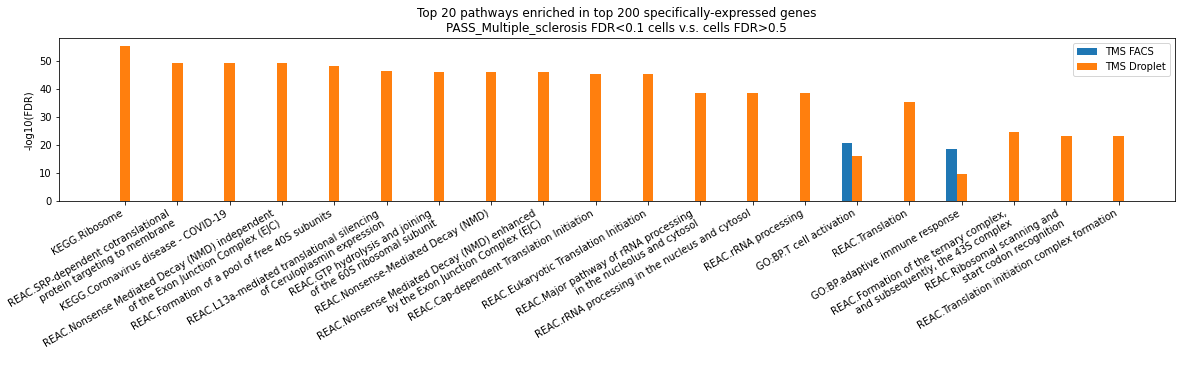

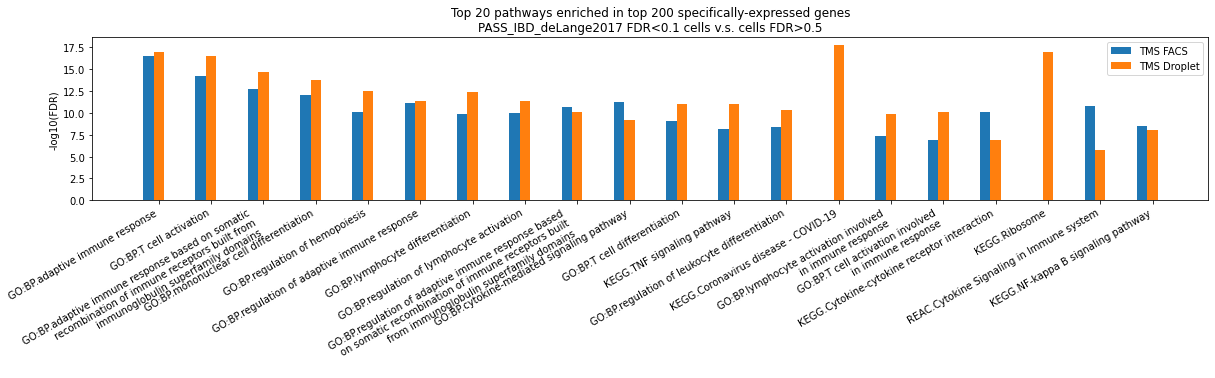

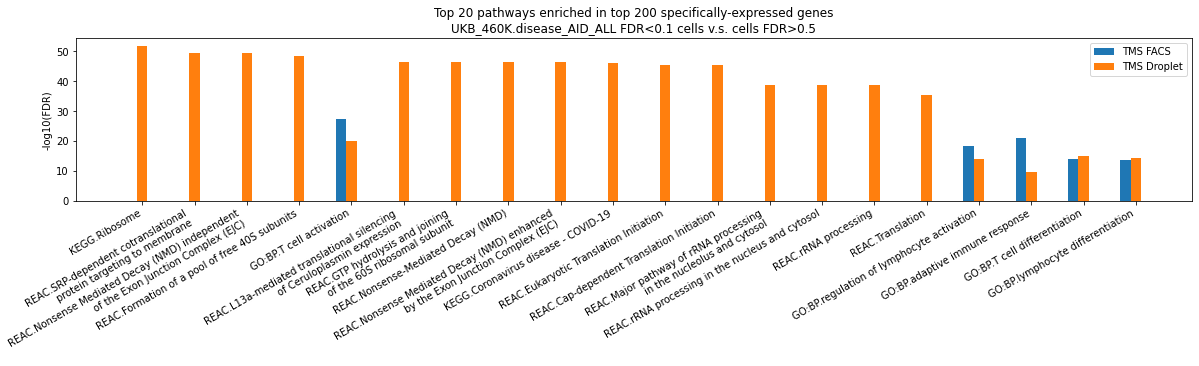

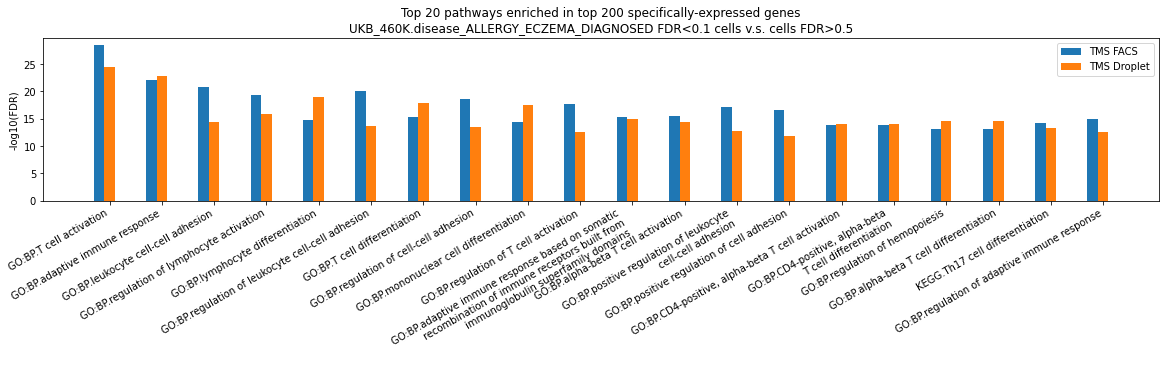

In [57]:
# Cross comparision: assoc-pathways 
def line_break(x):
    chr_ct = 0
    x_list = list(x)
    n_break = np.ceil(len(x)/50).astype(int)
    l_break = len(x)/n_break
    for i_chr in range(len(x)):
        if (chr_ct>l_break) & (x[i_chr]==' '):
            x_list[i_chr] = '\n'
            chr_ct=0
        chr_ct += 1
    return ''.join(x_list)

for trait in trait_list_plot:
    temp_list = []
    for i_ds,ds in enumerate(DS_LIST):
        temp_list.extend(dic_pathway['%s.%s.assoc'%(ds, trait)].index)
    df_plot = pd.DataFrame(index=sorted(set(temp_list)), columns=DS_LIST, data=0)
    for i_ds,ds in enumerate(DS_LIST):
        term_list = list(set(df_plot.index) & set(dic_pathway['%s.%s.assoc'%(ds, trait)].index))
        df_plot.loc[term_list, ds] = -np.log10(dic_pathway['%s.%s.assoc'%(ds, trait)].loc[term_list,'p_value'].values)

    df_plot['mean'] = df_plot.mean(axis=1)
    df_plot = df_plot.sort_values(by=['mean'], ascending=False).iloc[:20,:]
    df_plot['loc'] = range(df_plot.shape[0])
    df_plot.index = [line_break(x) for x in df_plot.index]

    plt.figure(figsize=[20,3])
    plt.bar(df_plot['loc']-0.2, df_plot['facs'], width=0.2, label='TMS FACS')
    plt.bar(df_plot['loc'], df_plot['droplet'], width=0.2, label='TMS Droplet')
    plt.xticks(df_plot['loc'], df_plot.index, ha='right', rotation=30)
    plt.ylabel('-log10(FDR)')
    plt.legend()
    plt.title('Top 20 pathways enriched in top 200 specifically-expressed genes\n%s FDR<0.1 cells v.s. cells FDR>0.5'%trait)
    plt.show()

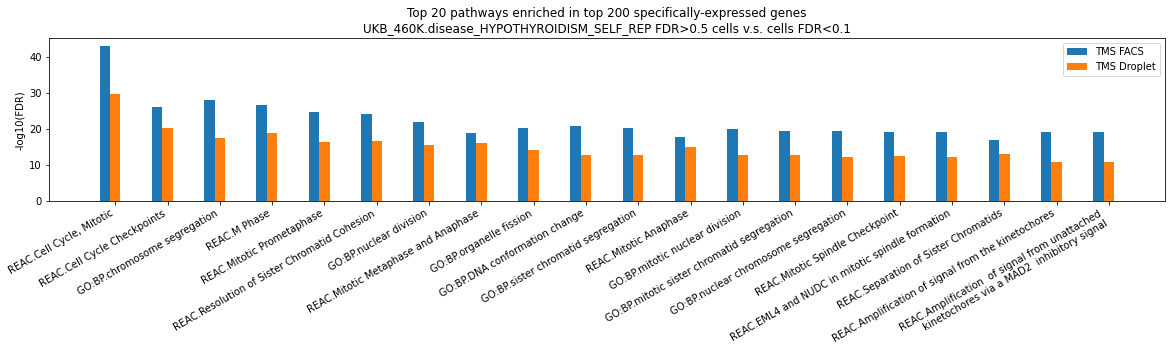

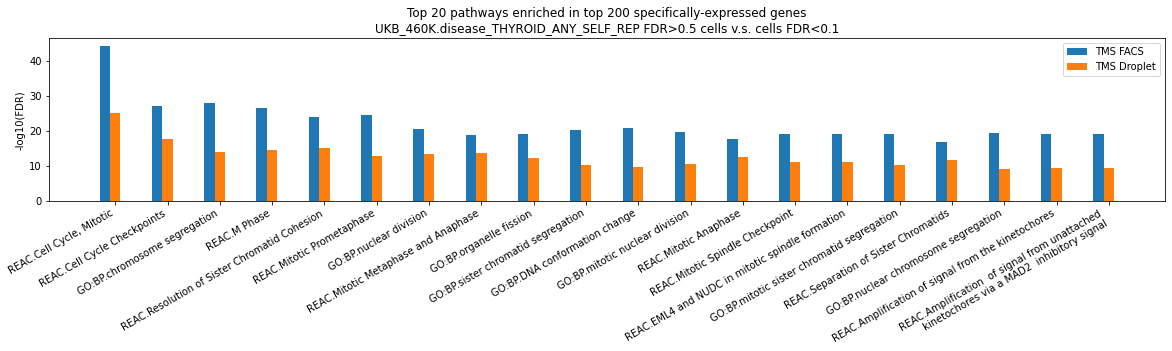

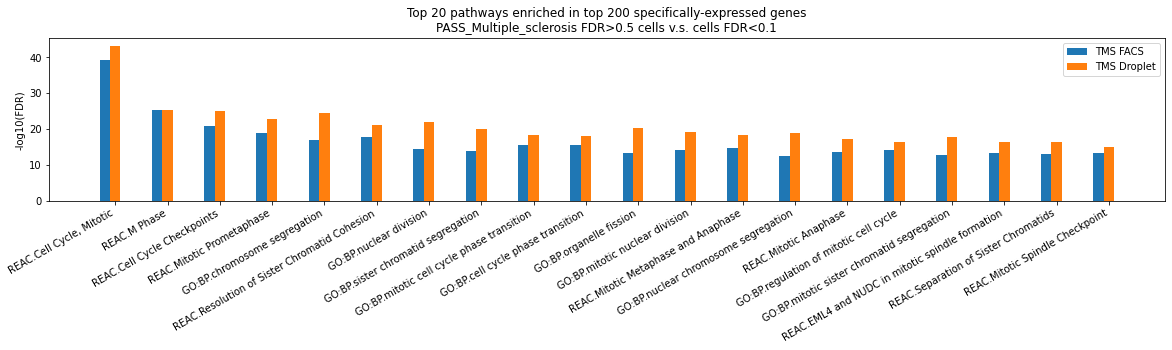

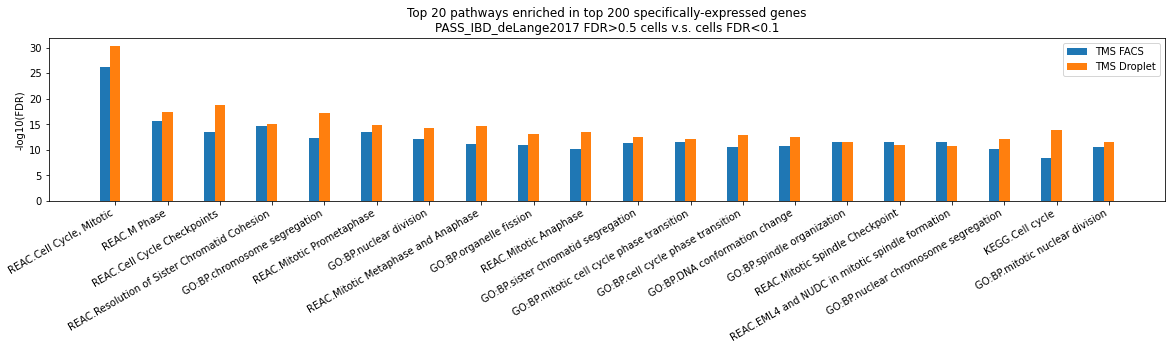

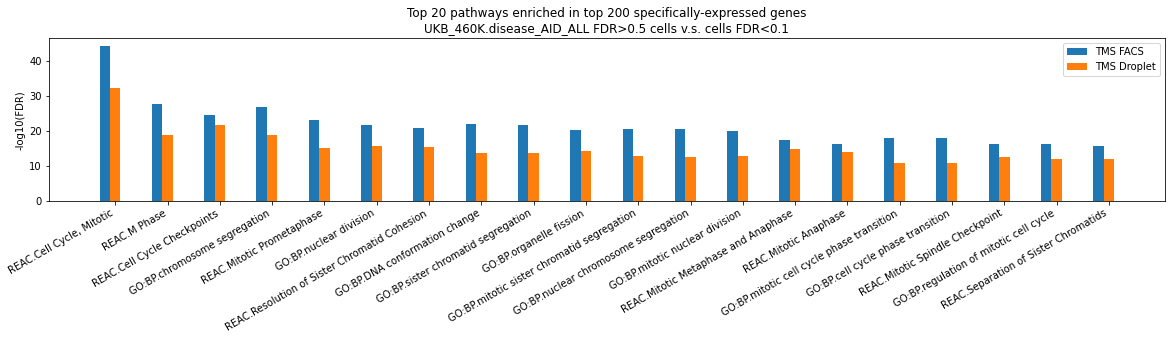

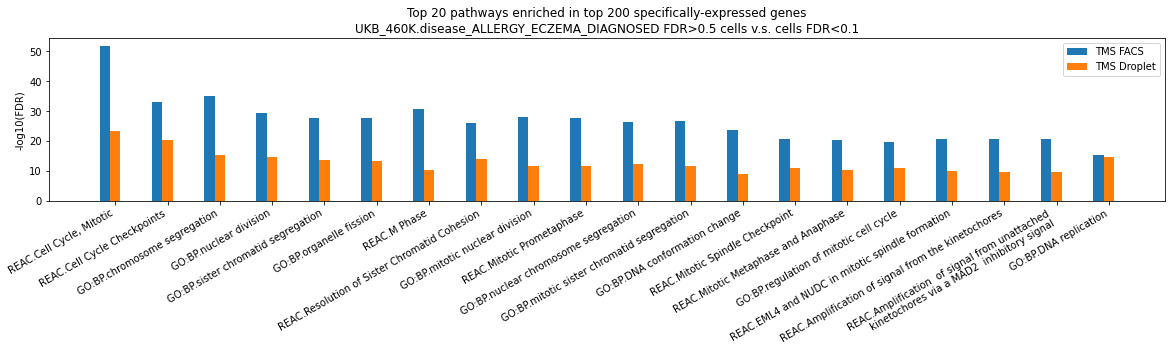

In [58]:
# Cross comparision: non-assoc-pathways 
for trait in trait_list_plot:
    temp_list = []
    for i_ds,ds in enumerate(DS_LIST):
        temp_list.extend(dic_pathway['%s.%s.non-assoc'%(ds, trait)].index)
    df_plot = pd.DataFrame(index=sorted(set(temp_list)), columns=DS_LIST, data=0)
    for i_ds,ds in enumerate(DS_LIST):
        term_list = list(set(df_plot.index) & set(dic_pathway['%s.%s.non-assoc'%(ds, trait)].index))
        df_plot.loc[term_list, ds] = -np.log10(dic_pathway['%s.%s.non-assoc'%(ds, trait)].loc[term_list,'p_value'].values)

    df_plot['mean'] = df_plot.mean(axis=1)
    df_plot = df_plot.sort_values(by=['mean'], ascending=False).iloc[:20,:]
    df_plot['loc'] = range(df_plot.shape[0])
    df_plot.index = [line_break(x) for x in df_plot.index]

    plt.figure(figsize=[20,3])
    plt.bar(df_plot['loc']-0.2, df_plot['facs'], width=0.2, label='TMS FACS')
    plt.bar(df_plot['loc'], df_plot['droplet'], width=0.2, label='TMS Droplet')
    plt.xticks(df_plot['loc'], df_plot.index, ha='right', rotation=30)
    plt.ylabel('-log10(FDR)')
    plt.legend()
    plt.title('Top 20 pathways enriched in top 200 specifically-expressed genes\n%s FDR>0.5 cells v.s. cells FDR<0.1'%trait)
    plt.show()